In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from matplotlib.pyplot import cm
from tqdm import tqdm_notebook

In [2]:
def filter_data(dfvz):
    # Filter Includes All Samples Containing Cysteine
    filter_cys = dfvz['seq'].str.contains('C')

    # Filter Includes All Samples Containing Proline in First Position but not in Second Position
    # I.e PCEQ is included but not PPEQ
    filter_proline = dfvz['seq'].str.contains('(^P[^P])')

    # Combined Filter to select any samples that satisfy either condition!
    filter_proline_cysteine = dfvz['seq'].str.contains('(^P[^P])|([C])')

    # Create index so it can be used for both DF20 and DFVZ (inverted to remove filtered rows)
    idx_filter_inverted = dfvz[~filter_proline_cysteine].index.to_list()

    print(f'Original Data Set Samples: {len(dfvz)}\
        \nSamples Containing Cystiene Residues: {len(dfvz[filter_cys])}\
        \nSamples Containing Proline (But Not Proline-Proline) {len(dfvz[filter_proline])}\
        \nTotal Samples that satisfy either condition (Some Overlap) {len(dfvz[filter_proline_cysteine])}\
        \nFinal Samples Used: {len(idx_filter_inverted)}\
        \nPercentage Removed: {len(idx_filter_inverted)/len(dfvz):.2%}')
    
    return idx_filter_inverted

In [3]:
dfvz = pd.read_csv('../DataFiles/experimental_data_set.csv', engine='c', index_col=0)
filtered_indices = filter_data(dfvz)
# Removes all Samples Containing C and PXXX where X != P
dfvz_filtered = dfvz.loc[filtered_indices]
dfvz_filtered.sort_values(inplace=True, by=['log.label'])
dfvz_compact = dfvz_filtered.loc[:, ['seq', 'log.label']]

Original Data Set Samples: 67278        
Samples Containing Cystiene Residues: 2740        
Samples Containing Proline (But Not Proline-Proline) 4328        
Total Samples that satisfy either condition (Some Overlap) 6846        
Final Samples Used: 60432        
Percentage Removed: 89.82%


In [4]:
top_1000 = dfvz_compact.iloc[-1000:]
bottom_1000 = dfvz_compact.iloc[:1000]
top_1000.sort_values(inplace=True, by=['log.label'], ascending=False)
bottom_1000.sort_values(inplace=True, by=['log.label'], ascending=False)
# bottom_100.to_csv('csv_files_explore/bottom_1000.csv')
# top_100.to_csv('csv_files_explore/top_1000.csv')

In [7]:
def descript_stats(dataframes):
    for df in dataframes:
        print('*'*50)
        mean = df['log.label'].mean()
        std = df['log.label'].std()
        minimum = df['log.label'].min()
        maximum = df['log.label'].max()
        print(f'{mean:.4f} +- {std:.4f}\nMin: {minimum:.4f}\nMaximum: {maximum:.4f}')

descript_stats([dfvz_compact, top_100, bottom_100])

,seq,log.label
31361,MPIP,-3.531919
45658,TYNQ,-3.532164
2376,GEEM,-3.533423
28220,NSMS,-3.534057
2939,MRTL,-3.536207
...,...,...
66718,GLIY,-4.439897
66739,MDFL,-4.439897
66774,WAIM,-4.439897
66699,WAVN,-4.439897


In [58]:
def normalize_counter(counter_dict):
    """
    Takes a counter dictionary with a structure of AA:Count and normalizes it so count/total_counts. Returns the normalized dict
    """
    total_aa = np.sum(list(counter_dict.values()))
    normalized_dict = {k:v/total_aa for (k, v) in counter_dict.items()}
    
    return normalized_dict


In [69]:
from collections import defaultdict
def aa_count(df, normalize):
    """
    Takes a given dataframe and counts the number of occurences of aa within the dataframe. Creates a dictionary with the structure AA:Count
    """
    aa_list = ['R','K','Q','E','D','N','Y','P','T','S','H','A','G','M','F','L','V','I','C','W']
    aa_counter_dict = defaultdict(int)
    for seq in df.seq.values:
        for a in aa_list:
            aa_counter_dict[a] += seq.count(a)

    # TODO: Remove after debugging complete: 
    print(np.sum(list(aa_counter_dict.values())))

    if normalize:
        return normalize_counter(aa_counter_dict)
    else:
        return aa_counter_dict


In [73]:
def base_normalize_aa_count(df_normalized_count, base_df_normalized_count):
    base_normalized_counter_dict = defaultdict(int)

    for k,v in df_normalized_count.items():
        base_normalized_counter_dict[k] = df_normalized_count[k] - base_df_normalized_count[k]

    return base_normalized_counter_dict


In [74]:
def aa_distrib_plotter(dfs, captions, colors=['orange', 'olive', 'gray'], normalize=False, normalize_base=False, base_df=None):
    """
    Takes a group of DFs and captions to create plots of their aa distributions. Can specify colors optionally via the colors argument. Can also specify if the plot should be normalized. Max 3 plots at a time. To normalize to a base, set normalize_base to True and give a base df to normalize against. 
    """
    num_df = len(dfs)
    fig, axes = plt.subplots(1, num_df, figsize=(8*num_df, 6))
    
    for n, df in enumerate(dfs):
        
        if normalize_base:
            base_aa_count = aa_count(base_df, normalize=True)
            target_aa_count = aa_count(df, normalize=True)
            aa_counter_dict = base_normalize_aa_count(target_aa_count, base_aa_count)

        else:
            aa_counter_dict = aa_count(df, normalize=normalize)

        if len(dfs) == 1:
            axes.bar(*zip(*aa_counter_dict.items()), color=colors[n])
            axes.set_ylabel('Number of Occurences of AA')
            axes.set_title(captions[n])

        else:
            axes[n].bar(*zip(*aa_counter_dict.items()), color=colors[n])
            axes[n].set_ylabel('Number of Occurences of AA')
            axes[n].set_title(captions[n])



241728
4000
241728
4000


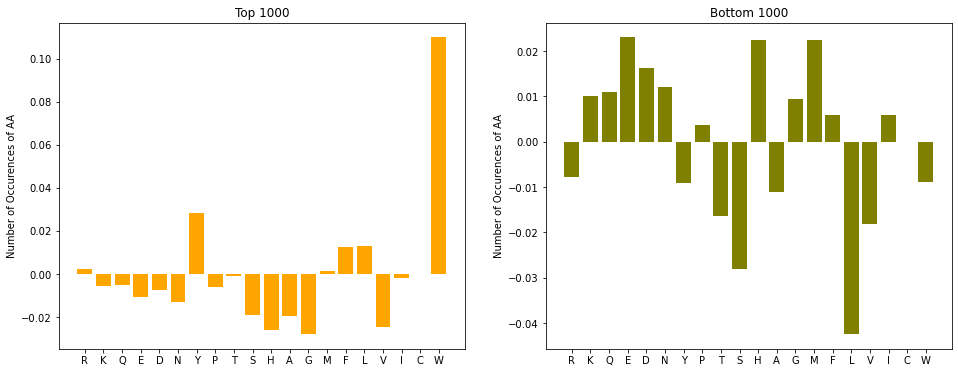

In [75]:
aa_distrib_plotter([top_1000, bottom_1000], ['Top 1000', 'Bottom 1000'], normalize_base=True,base_df=dfvz_filtered)

4000
241728


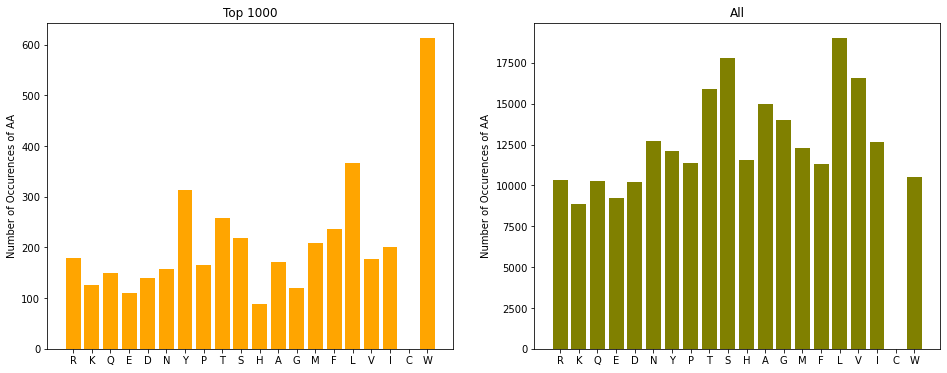

In [79]:
aa_distrib_plotter([top_1000, dfvz_filtered], ['Top 1000', 'All'], normalize=False)